<a href="https://colab.research.google.com/github/bintualkassoum/bintualkassoum/blob/main/CompasFairML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objective: The goal of this project is to identify which factors have the strongest impact on recidivism rates. Aligning with O'Neil (Weapons of Math Destrcution), I argue that predictive models have the potential to generate negative feedback loops, which can then impact the individuals represented in these models. These feedback loops are perpetuated by their opacity, scale, and societal damage. 

I will then analyze these results against COMPAS in an attempt to re-create a better, less harmful, and more effective model. 

Afterwards, I will run this model against other data sets to ensure its effectiveness, as this data set is limited to Broward County, Florida. 

Feature Engineering Info: 
Drop age_cat, first, last, 
c_jail_in and c_jail_out (several values small time frame and similar), 
c_days_from_compas (too many similar values across rows), 

In [304]:
#Import Packages
import pandas as pd 
import os 
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
!pip install --upgrade category_encoders
import category_encoders as ce
%matplotlib inline

In [339]:
#Import Libraries 
from pandas import read_csv
from pandas.plotting import scatter_matrix
from pandas.core.common import random_state
from sklearn import neighbors, metrics, utils
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.inspection import permutation_importance

In [306]:
#Import Offender Data Set
off_data = pd.read_csv('/content/cox-violent-parsed.csv')
print(off_data.head(5))

print(off_data.shape)

off_data.head()

    id              name    first       last  ... priors_count.1 start  end  event
0  1.0  miguel hernandez   miguel  hernandez  ...              0     0  327      0
1  2.0  miguel hernandez   miguel  hernandez  ...              0   334  961      0
2  3.0      michael ryan  michael       ryan  ...              0     3  457      0
3  4.0       kevon dixon    kevon      dixon  ...              0     9  159      1
4  5.0          ed philo       ed      philo  ...              4     0   63      0

[5 rows x 52 columns]
(18316, 52)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,13011352CF10A,13/08/2013,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,13011352CF10A,13/08/2013,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,0,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,0,3,0,0,0,-1.0,26/01/2013 3:45,05/02/2013 5:36,13001275CF10A,26/01/2013,NaN,1.0,(F3),Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,05/07/2013,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,13005330CF10A,13/04/2013,NaN,1.0,(F3),Possession of Cocaine,1,13011511MM10A,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,16/06/2013,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0


In [307]:
#Check Null Values (Offender Data)
total_nulls = off_data.isnull().sum()
total_observations = off_data.shape[0]

null_percentages = total_nulls[total_nulls > 0] / total_observations * 100
total_nulls = total_nulls[total_nulls > 0]

pd.concat([total_nulls, null_percentages], axis = 1, keys = ["Total Nulls", "Percentage"]).sort_values(by = "Total Nulls", ascending = False)


,Total Nulls,Percentage
violent_recid,18316,100.000000
vr_charge_desc,16977,92.689452
vr_offense_date,16977,92.689452
vr_charge_degree,16977,92.689452
vr_case_number,16977,92.689452
c_arrest_date,15231,83.156803
r_jail_out,11957,65.281721
r_jail_in,11957,65.281721
r_days_from_arrest,11957,65.281721
r_charge_desc,10039,54.810002


In [308]:
#Drop Null Values 
off_data.dropna(axis='columns', thresh= 17000)

,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,is_violent_recid,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,13011352CF10A,1.0,(F3),Aggravated Assault w/Firearm,0,0,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,13011352CF10A,1.0,(F3),Aggravated Assault w/Firearm,0,0,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,0,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,0,3,0,0,0,-1.0,26/01/2013 3:45,05/02/2013 5:36,13001275CF10A,1.0,(F3),Felony Battery w/Prior Convict,1,1,Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,13005330CF10A,1.0,(F3),Possession of Cocaine,1,0,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18311,alexsandra beauchamps,alexsandra,beauchamps,29/12/2014,Female,21/12/1984,31,25 - 45,African-American,0,6,0,0,5,-1.0,28/12/2014 10:14,07/01/2015 11:42,14018106MM10A,1.0,(M1),Battery,0,0,Risk of Recidivism,6,Medium,29/12/2014,Risk of Violence,4,Low,29/12/2014,28/12/2014,07/01/2015,5,9,459,0
18312,winston gregory,winston,gregory,14/01/2014,Male,01/10/1958,57,Greater than 45,Other,0,1,0,0,0,-1.0,13/01/2014 5:48,14/01/2014 7:49,14000581CF10A,1.0,(F2),Aggravated Battery / Pregnant,0,0,Risk of Recidivism,1,Low,14/01/2014,Risk of Violence,1,Low,14/01/2014,13/01/2014,14/01/2014,0,0,808,0
18313,farrah jean,farrah,jean,09/03/2014,Female,17/11/1982,33,25 - 45,African-American,0,2,0,0,3,-1.0,08/03/2014 8:06,09/03/2014 12:18,14003308CF10A,1.0,(M1),Battery on Law Enforc Officer,0,0,Risk of Recidivism,2,Low,09/03/2014,Risk of Violence,2,Low,09/03/2014,08/03/2014,09/03/2014,3,0,754,0
18314,florencia sanmartin,florencia,sanmartin,30/06/2014,Female,18/12/1992,23,Less than 25,Hispanic,0,4,0,0,2,-2.0,28/06/2014 12:16,30/06/2014 11:19,14008895CF10A,2.0,(F3),Possession of Ethylone,1,0,Risk of Recidivism,4,Low,30/06/2014,Risk of Violence,4,Low,30/06/2014,15/03/2015,15/03/2015,2,0,258,0


In [309]:
#Drop Duplicate Rows 
off_data.drop_duplicates(subset=['name', 'score_text'], keep='first')
off_data[off_data.duplicated(keep='first')]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event


In [310]:
#Combine all Juvenile Counts 
off_data['juv_misd_count']. value_counts()

off_data['juv_fel_count']. value_counts()

off_data['juv_other_count']. value_counts()

juv_count = off_data['juv_misd_count'] + off_data['juv_fel_count'] + off_data['juv_other_count']
off_data['juv_count'] = juv_count

In [311]:
#Combine Custody Dates 
off_data['in_custody'] = pd.to_datetime(off_data['in_custody'])
off_data['out_custody'] = pd.to_datetime(off_data['out_custody'])
off_data['custody_duration'] = (off_data['out_custody'] - off_data['in_custody']).dt.days

#Several dates inputted incorrectly, so I will drop all three categories 

In [312]:
#Combine Violent and Non-Violent Recidivisim (Target Variable)
total_recid = off_data['is_recid'] + off_data['is_violent_recid']
off_data['total_recid'] = total_recid

In [313]:
#Combine Decile and Violent Decile Scores (Target Variable)
recid_score = (off_data['decile_score'] + off_data['v_decile_score']) / 2
off_data['recid_score'] = recid_score

off_data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,juv_count,custody_duration,total_recid,recid_score
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,13011352CF10A,13/08/2013,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,2014-07-07,2014-07-14,0,0,327,0,0,7.0,0,1.0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,13011352CF10A,13/08/2013,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,2014-07-07,2014-07-14,0,334,961,0,0,7.0,0,1.0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,0,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,31/12/2014,2014-12-30,2015-03-01,0,3,457,0,0,61.0,-1,3.5
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,0,3,0,0,0,-1.0,26/01/2013 3:45,05/02/2013 5:36,13001275CF10A,26/01/2013,NaN,1.0,(F3),Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,05/07/2013,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,27/01/2013,2013-01-26,2013-05-02,0,9,159,1,0,96.0,2,2.0
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,13005330CF10A,13/04/2013,NaN,1.0,(F3),Possession of Cocaine,1,13011511MM10A,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,16/06/2013,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,14/04/2013,2013-06-16,2013-06-16,4,0,63,0,1,0.0,1,3.5


In [314]:
#Final Data Cleaning 

column_names = ['sex', 'age', 'race', 'juv_count', 'priors_count',
                'c_charge_degree', 'recid_score']
data = pd.DataFrame(off_data, columns=column_names)

data.loc[data['recid_score'] == -1]
data = data.drop([900, 1269, 1270, 5018, 13669, 17695])

data = data.dropna()

data.head()

,sex,age,race,juv_count,priors_count,c_charge_degree,recid_score
0,Male,69,Other,0,0,(F3),1.0
1,Male,69,Other,0,0,(F3),1.0
3,Male,34,African-American,0,0,(F3),2.0
4,Male,24,African-American,1,4,(F3),3.5
5,Male,24,African-American,1,4,(F3),3.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  import sys


,Skew
age,0.967979
juv_count,6.429956
priors_count,2.157521
recid_score,0.282958


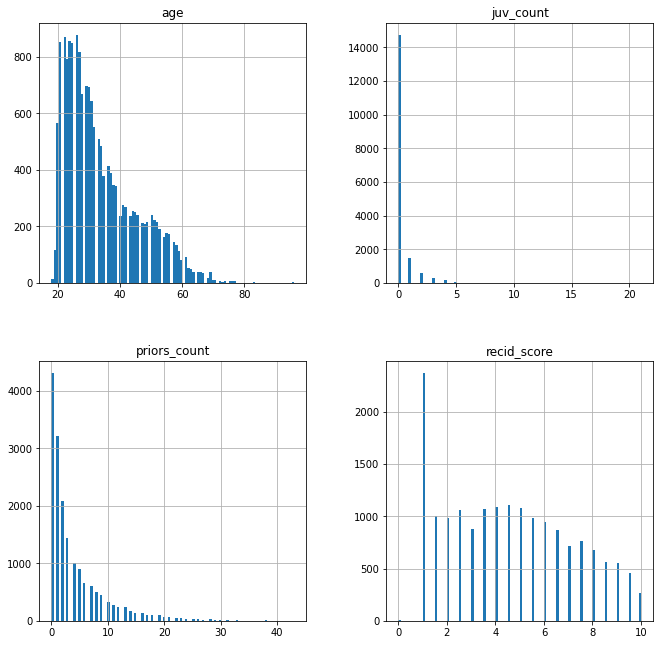

In [315]:
#Exploratory Data Analysis 
data_num = data[['age', 'juv_count', 'priors_count', 'recid_score']]
data_cat = data[['sex', 'race', 'c_charge_degree']] 

#Data Distribution 
fig, ax = plt.subplots(figsize=(11, 11))
data.hist(bins=100, ax=ax)

#Skew of Data 
skew = data.skew()
pd.DataFrame(data = skew, columns=['Skew'])

In [316]:
#Pivot Tables for Categorical Variables 
print(pd.pivot_table(data, index = 'recid_score', columns = 'sex', values = 'age', aggfunc = 'count'))
print(pd.pivot_table(data, index = 'recid_score', columns = 'race', values = 'age', aggfunc = 'count'))
print(pd.pivot_table(data, index = 'recid_score', columns = 'c_charge_degree', values = 'age', aggfunc = 'count'))
print(pd.pivot_table(data, index = 'recid_score', values = ['age', 'juv_count', 'priors_count']))

sex          Female  Male
recid_score              
0.0               2     1
1.0             509  1859
1.5             200   807
2.0             257   728
2.5             180   883
3.0             220   655
3.5             222   847
4.0             219   870
4.5             236   867
5.0             209   873
5.5             193   794
6.0             173   774
6.5             101   771
7.0              93   620
7.5             110   650
8.0              91   589
8.5              54   507
9.0              56   500
9.5              62   399
10.0              9   254
race         African-American  Asian  ...  Native American  Other
recid_score                           ...                        
0.0                       NaN    NaN  ...              NaN    1.0
1.0                     606.0   24.0  ...              6.0  239.0
1.5                     371.0    8.0  ...              5.0   80.0
2.0                     419.0    3.0  ...              3.0   66.0
2.5                     449.0   

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


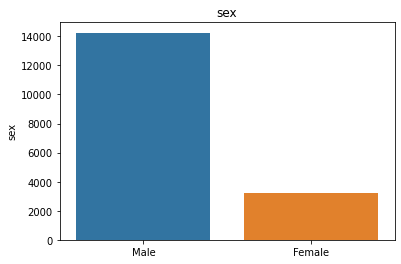

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


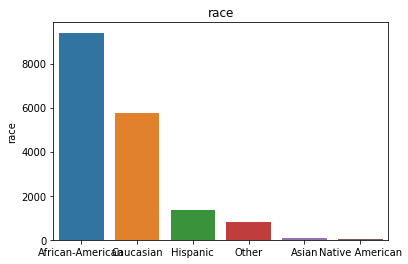

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


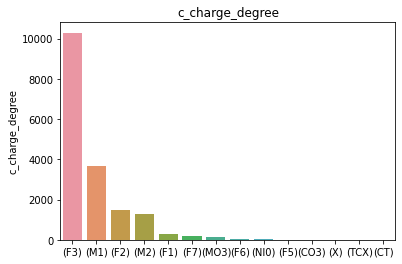

In [317]:
#Histograph for Categorical Features 
for i in data_cat.columns:
    sns.barplot(data_cat[i].value_counts().index,data_cat[i].value_counts()).set_title(i)
    plt.show()

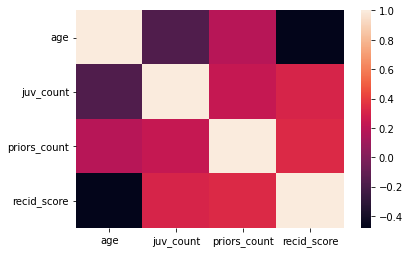

In [318]:
#Data Visulaization - Heatmap Plot
corr = data.corr()

sns.heatmap(corr)

In [ ]:
#Split Original Data Set 
X = data.drop(['recid_score'], axis=1)
y = data['recid_score']

data.isnull().any()
data = data.fillna(lambda x: x.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=8)

print("X_train Shape: {}".format(X_train.shape))
print("X_test Shape: {}".format(X_test.shape))
print("y_train Shape: {}".format(y_train.shape))
print("y_test Shape: {}".format(y_test.shape))

In [320]:
#Label Encoding 
enc = LabelEncoder()

#Training Set 
X_train['sex'] = enc.fit_transform(X_train['sex'])
X_train['race'] = enc.fit_transform(X_train['race'])
X_train['c_charge_degree'] = enc.fit_transform(X_train['c_charge_degree'])

#Test Set 
X_test['sex'] = enc.fit_transform(X_test['sex'])
X_test['race'] = enc.fit_transform(X_test['race'])
X_test['c_charge_degree'] = enc.fit_transform(X_test['c_charge_degree'])

X_train.describe()


,sex,age,race,juv_count,priors_count,c_charge_degree
count,13955.000000,13955.000000,13955.000000,13955.000000,13955.000000,13955.000000
mean,0.818703,33.915586,1.132999,0.310928,4.136224,4.190398
std,0.385278,11.596479,1.380549,1.002000,5.373148,2.108616
min,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,25.000000,0.000000,0.000000,1.000000,3.000000
50%,1.000000,31.000000,0.000000,0.000000,2.000000,3.000000
75%,1.000000,41.000000,2.000000,0.000000,6.000000,7.000000
max,1.000000,96.000000,5.000000,21.000000,43.000000,11.000000


In [ ]:
#Feature Engineering - Age 
data = [X_train, X_test]

for dataset in data:
    dataset['age'] = dataset['age'].astype(int)
    dataset.loc[(dataset['age'] > 17) & (dataset['age'] <= 30), 'age'] = 0
    dataset.loc[(dataset['age'] > 30) & (dataset['age'] <= 40), 'age'] = 1
    dataset.loc[(dataset['age'] > 40) & (dataset['age'] <= 50), 'age'] = 2
    dataset.loc[(dataset['age'] > 50) & (dataset['age'] <= 60), 'age'] = 3
    dataset.loc[ dataset['age'] > 60, 'age'] = 4

X_train.head(50)

In [ ]:
#Encoding Features 
enc = LabelEncoder()

y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)

print(y_train)
print(utils.multiclass.type_of_target(y_train.astype('int')))
print(utils.multiclass.type_of_target(y_train))

print(utils.multiclass.type_of_target(y_test))

In [335]:
#Building ML Models 

#Random Forest:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)

#Logistic Regression:
logreg = LogisticRegression(max_iter=3000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, y_train) * 100, 2)


#K Nearest Neighbor (KNN):
knn = neighbors.KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

acc_knn = round(knn.score(X_train, y_train) * 100, 2)

#Gaussian Naive Bayes:
gaussian = GaussianNB() 
gaussian.fit(X_train, y_train)  

y_pred = gaussian.predict(X_test) 

acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)

#Results
results = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'KNN', 'Naive Bayes'],
    'Score': [acc_random_forest, acc_log, acc_knn, acc_gaussian]})
result_data = results.sort_values(by='Score', ascending=False)
result_data = result_data.set_index('Score')
result_data.head()

,Model
Score,
44.84,Random Forest
36.47,KNN
19.89,Logistic Regression
13.70,Naive Bayes


In [ ]:
#Confusion Matrix 
print(confusion_matrix(y_test, y_pred))

In [338]:
#Cross Validation 

print(cross_val_score(random_forest, X_train, y_train, cv=3).mean())

print(cross_val_score(logreg, X_train, y_train, cv=3).mean())

print(cross_val_score(knn, X_train, y_train, cv=3).mean())

print(cross_val_score(gaussian, X_train, y_train, cv=3).mean())

0.31257641810527287
0.1978501065393408
0.2599781917417267
0.13844688275754885


In [341]:
#Grid Search Parameters
random_forest = RandomForestClassifier(random_state=42)

n_estimators = [10, 100, 1000, 2000]
max_depth = [None, 5, 10, 20]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

grid = GridSearchCV(estimator=random_forest, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

#Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.312791 using {'max_depth': None, 'n_estimators': 2000}
0.308420 (0.003464) with: {'max_depth': None, 'n_estimators': 10}
0.311860 (0.002897) with: {'max_depth': None, 'n_estimators': 100}
0.311501 (0.003363) with: {'max_depth': None, 'n_estimators': 1000}
0.312791 (0.005194) with: {'max_depth': None, 'n_estimators': 2000}
0.210606 (0.002394) with: {'max_depth': 5, 'n_estimators': 10}
0.213758 (0.003744) with: {'max_depth': 5, 'n_estimators': 100}
0.218130 (0.003840) with: {'max_depth': 5, 'n_estimators': 1000}
0.218201 (0.004103) with: {'max_depth': 5, 'n_estimators': 2000}
0.283411 (0.007516) with: {'max_depth': 10, 'n_estimators': 10}
0.296167 (0.004995) with: {'max_depth': 10, 'n_estimators': 100}
0.298674 (0.000984) with: {'max_depth': 10, 'n_estimators': 1000}
0.298388 (0.001155) with: {'max_depth': 10, 'n_estimators': 2000}
0.307990 (0.003148) with: {'max_depth': 20, 'n_estimators': 10}
0.312218 (0.002972) with: {'max_depth': 20, 'n_estimators': 100}
0.311071 (0.003208) w